# Imports

In [28]:
import pandas as pd
import time
import numpy as np
from langdetect import detect

# Standard data processing libraries
import pandas as pd
import numpy as np
import string

# Libraries for NLP
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Language Detection Library
import fasttext as ft

# Deep learning libraries
import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,Embedding, Bidirectional

# Libraries for visualization
import plotly.express as px
import plotly.io as pio

# Setting template for all plots
pio.templates.default = "simple_white"

# Load/Data Exploration

In [29]:
#Read the data
start = time.time()
df = pd.read_csv("billboard_2012_to_2022_top_100_song_lyrics.csv", encoding = "ISO-8859-1")
end = time.time()

#Print the time it took to load the data
print("Time to load the data: ", end - start)

Time to load the data:  0.01880645751953125


In [30]:
#Show the first 5 rows
df.head()

,Top100Year,SongTitle,Artist,LyricsStatus,Lyrics,ReleaseYear,Genre
0,2012,Call Me Maybe,Carly Rae Jepsen,True,"I threw a wish in the well\nDon't ask me, I'll...",2012,"R&B/Soul, Pop"
1,2012,Payphone,Maroon 5 Featuring Wiz Khalifa,True,I'm at a payphone trying to call home\nAll of ...,2012,"R&B/Soul, Pop"
2,2012,Somebody That I Used To Know,Gotye Featuring Kimbra,True,Now and then I think of when we were together\...,2011,"R&B/Soul, Pop"
3,2012,Wide Awake,Katy Perry,True,I'm wide awake\nI'm wide awake\nI'm wide awake...,2012,"R&B/Soul, Pop, UK R&B"
4,2012,Where Have You Been,Rihanna,True,"I've been everywhere, man\nLooking for someone...",2011,"Dance-pop, R&B/Soul, Electro house, Pop, UK R&B"


In [31]:
#Show the last 5 rows
df.tail()

,Top100Year,SongTitle,Artist,LyricsStatus,Lyrics,ReleaseYear,Genre
1095,2022,N95,Kendrick Lamar,True,"Hello, new world, all the boys and girls\nI go...",2022,"Pop, Country"
1096,2022,Love Me More,Sam Smith,True,Have you ever felt like being somebody else?\n...,2022,"R&B/Soul, Pop"
1097,2022,New Truck,Dylan Scott,True,I need a new truck\nThere ain't nothing wrong ...,2022,"R&B/Soul, Pop"
1098,2022,She's All I Wanna Be,Tate McRae,True,You want the girl with the small waist\nAnd th...,2022,"R&B/Soul, Pop"
1099,2022,Desesperados,Rauw Alejandro & Chencho Corleone,True,Â¿QuÃ© me hizo usted?\nQue la quiero volver a ...,2021,"R&B/Soul, Pop"


In [32]:
#Summary of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Top100Year    1100 non-null   int64 
 1   SongTitle     1100 non-null   object
 2   Artist        1100 non-null   object
 3   LyricsStatus  1100 non-null   bool  
 4   Lyrics        962 non-null    object
 5   ReleaseYear   1100 non-null   object
 6   Genre         1100 non-null   object
dtypes: bool(1), int64(1), object(5)
memory usage: 52.8+ KB


In [33]:
#Describe statistics of the data
df.describe()

,Top100Year
count,1100.000000
mean,2017.000000
std,3.163716
min,2012.000000
25%,2014.000000
50%,2017.000000
75%,2020.000000
max,2022.000000


In [34]:
#Dimensions of the data as a tuple
df.shape

(1100, 7)

In [35]:
#Columns names of the data
df.columns

Index(['Top100Year', 'SongTitle', 'Artist', 'LyricsStatus', 'Lyrics',
       'ReleaseYear', 'Genre'],
      dtype='object')

In [36]:
#Data types of each column
df.dtypes

Top100Year       int64
SongTitle       object
Artist          object
LyricsStatus      bool
Lyrics          object
ReleaseYear     object
Genre           object
dtype: object

In [37]:
#Missing or null values in the data
df.isnull()

,Top100Year,SongTitle,Artist,LyricsStatus,Lyrics,ReleaseYear,Genre
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1095,False,False,False,False,False,False,False
1096,False,False,False,False,False,False,False
1097,False,False,False,False,False,False,False
1098,False,False,False,False,False,False,False


# Data Preparation

In [38]:
#Removing records where lyrics status=False as lyrics are not available
df1 = df[df['LyricsStatus'] == True]

In [39]:
#Dropping Lyrics Status as it is not required for analysis
df1.drop('LyricsStatus', inplace=True, axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 962 entries, 0 to 1099
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Top100Year   962 non-null    int64 
 1   SongTitle    962 non-null    object
 2   Artist       962 non-null    object
 3   Lyrics       962 non-null    object
 4   ReleaseYear  962 non-null    object
 5   Genre        962 non-null    object
dtypes: int64(1), object(5)
memory usage: 52.6+ KB


<ipython-input-39-60f3dd9e0b58>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
#Identifying the language of the lyrics using FastText
language = list()

# Load the facebook pretrained model
ft_model = ft.load_model("lid.176.ftz")

def fasttext_language_predict(text, model = ft_model):
    text = text.replace('\n', " ")
    prediction = model.predict([text])
    return prediction

for lyrics in df1['Lyrics']:
    pred = fasttext_language_predict(lyrics)
    language.append(pred[0][0][0][-2:])

df1.loc[:,'Language'] = language
df1

<ipython-input-40-1495651256ec>:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Top100Year,SongTitle,Artist,Lyrics,ReleaseYear,Genre,Language
0,2012,Call Me Maybe,Carly Rae Jepsen,"I threw a wish in the well\nDon't ask me, I'll...",2012,"R&B/Soul, Pop",en
1,2012,Payphone,Maroon 5 Featuring Wiz Khalifa,I'm at a payphone trying to call home\nAll of ...,2012,"R&B/Soul, Pop",en
2,2012,Somebody That I Used To Know,Gotye Featuring Kimbra,Now and then I think of when we were together\...,2011,"R&B/Soul, Pop",en
3,2012,Wide Awake,Katy Perry,I'm wide awake\nI'm wide awake\nI'm wide awake...,2012,"R&B/Soul, Pop, UK R&B",en
4,2012,Where Have You Been,Rihanna,"I've been everywhere, man\nLooking for someone...",2011,"Dance-pop, R&B/Soul, Electro house, Pop, UK R&B",en
...,...,...,...,...,...,...,...
1095,2022,N95,Kendrick Lamar,"Hello, new world, all the boys and girls\nI go...",2022,"Pop, Country",en
1096,2022,Love Me More,Sam Smith,Have you ever felt like being somebody else?\n...,2022,"R&B/Soul, Pop",en
1097,2022,New Truck,Dylan Scott,I need a new truck\nThere ain't nothing wrong ...,2022,"R&B/Soul, Pop",en
1098,2022,She's All I Wanna Be,Tate McRae,You want the girl with the small waist\nAnd th...,2022,"R&B/Soul, Pop",en


In [41]:
#Count of songs in each language
df1['Language'].value_counts()

#Choosing lyrics entries with English language
df_en = df1[df1['Language']=='en']
df_en.drop(columns=['Language'], inplace=True)
df_en.reset_index(drop=True, inplace=True)

<ipython-input-41-26636f7f44a5>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
#Removing repeated songs (by Title)
df_en.drop_duplicates(subset = ['SongTitle'], inplace=True)

<ipython-input-42-aa503e9710cb>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
#Removing unnecessary characters from lyrics
df_en['rem_sp_char'] = df_en['Lyrics'].str.replace("[\(\[].*?[\)\]]", '')
df_en['rem_sp_char'] = df_en['rem_sp_char'].str.replace("\n", ' ')
df_en['rem_sp_char'] = df_en['rem_sp_char'].str.lower()
df_en['rem_sp_char'] = df_en['rem_sp_char'].str.replace('[{}]'.format(string.punctuation), '')

<ipython-input-43-037b43790fc1>:2: FutureWarning:

The default value of regex will change from True to False in a future version.

<ipython-input-43-037b43790fc1>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-037b43790fc1>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-037b43790fc1>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [44]:
def remove_stopwords(text):    # text is a list/series of string to clean
    clean_text = list()
    nltk.download('punkt')
    nltk.download('stopwords')
    
    words=["yeah","ya","na","wan","uh","gon","ima","mm","uhhuh","bout","em","nigga","niggas","got","ta","lil","ol","hey",
          "oooh","ooh","oh","youre","dont","im","youve","ive","theres","ill","yaka","lalalala","la","da","di","yuh",
          "shawty","oohooh","shoorah","mmmmmm","ook","bidibambambambam","shh","bro","ho","aint","cant","know","bambam",
          "shitll","tonka"]
    ignore= (stopwords.words('english') + words)
    
    for i in text:
        words = nltk.word_tokenize(i)
        #for i in range(len(words)):
        #    words = [w for w in words if w not in stopwords.words('english')]
        for element in ignore: # given the tokenized list, return a list that doesn't contain any of the elements
            words = list(filter(lambda x: x!= element and len(x) > 1, words))
        lyric = " ".join(words)
        clean_text.append(lyric)
    
    return clean_text
        
df_en['LyricsClean'] = remove_stopwords(df_en['rem_sp_char'])

[nltk_data] Downloading package punkt to /home/pereira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/pereira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-44-3c9420b8ea82>:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
df_en.reset_index(drop=True, inplace=True)

df_en

,Top100Year,SongTitle,Artist,Lyrics,ReleaseYear,Genre,rem_sp_char,LyricsClean
0,2012,Call Me Maybe,Carly Rae Jepsen,"I threw a wish in the well\nDon't ask me, I'll...",2012,"R&B/Soul, Pop",i threw a wish in the well dont ask me ill nev...,threw wish well ask never tell looked fell way...
1,2012,Payphone,Maroon 5 Featuring Wiz Khalifa,I'm at a payphone trying to call home\nAll of ...,2012,"R&B/Soul, Pop",im at a payphone trying to call home all of my...,payphone trying call home change spent times g...
2,2012,Somebody That I Used To Know,Gotye Featuring Kimbra,Now and then I think of when we were together\...,2011,"R&B/Soul, Pop",now and then i think of when we were together ...,think together like said felt happy could die ...
3,2012,Wide Awake,Katy Perry,I'm wide awake\nI'm wide awake\nI'm wide awake...,2012,"R&B/Soul, Pop, UK R&B",im wide awake im wide awake im wide awake yeah...,wide awake wide awake wide awake dark falling ...
4,2012,Where Have You Been,Rihanna,"I've been everywhere, man\nLooking for someone...",2011,"Dance-pop, R&B/Soul, Electro house, Pop, UK R&B",ive been everywhere man looking for someone so...,everywhere man looking someone someone please ...
...,...,...,...,...,...,...,...,...
903,2022,F.N.F. (Let's Go),Hitkidd & Glorilla,"HitKidd, what it do man?\nGloRilla, mmm-hmm\nL...",2022,"Pop, Country",hitkidd what it do man glorilla mmmhmm let go ...,hitkidd man glorilla mmmhmm let go woo woo gan...
904,2022,N95,Kendrick Lamar,"Hello, new world, all the boys and girls\nI go...",2022,"Pop, Country",hello new world all the boys and girls i got s...,hello new world boys girls true stories tell b...
905,2022,Love Me More,Sam Smith,Have you ever felt like being somebody else?\n...,2022,"R&B/Soul, Pop",have you ever felt like being somebody else fe...,ever felt like somebody else feeling like mirr...
906,2022,New Truck,Dylan Scott,I need a new truck\nThere ain't nothing wrong ...,2022,"R&B/Soul, Pop",i need a new truck there aint nothing wrong wi...,need new truck nothing wrong mine forty someth...


## Sentiment Analysis using NLP

In [46]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

comp_score = []
sentiment = []

for i in df_en.loc[:,'LyricsClean']:
    sentiment.append(sia.polarity_scores(i))

# Compound score is the sum of positive, negative & neutral scores 
# which is then normalized between -1(most extreme negative) and +1 (most extreme positive).
df_en.loc[:,'sent_scores'] = sentiment
df_en.loc[:,'comp_score'] = df_en.loc[:,'sent_scores'].apply(lambda x: x['compound'])
df_en.loc[:,'sentiment'] = df_en.loc[:,'comp_score'].apply(lambda x: 'Positive' if x>=0.5 else 'Negative' if x<=-0.5 else 'Neutral')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/pereira/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-46-0ba14fd2be3e>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-0ba14fd2be3e>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-46-0ba14fd2be3e>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [47]:
df_en

,Top100Year,SongTitle,Artist,Lyrics,ReleaseYear,Genre,rem_sp_char,LyricsClean,sent_scores,comp_score,sentiment
0,2012,Call Me Maybe,Carly Rae Jepsen,"I threw a wish in the well\nDon't ask me, I'll...",2012,"R&B/Soul, Pop",i threw a wish in the well dont ask me ill nev...,threw wish well ask never tell looked fell way...,"{'neg': 0.321, 'neu': 0.567, 'pos': 0.112, 'co...",-0.9936,Negative
1,2012,Payphone,Maroon 5 Featuring Wiz Khalifa,I'm at a payphone trying to call home\nAll of ...,2012,"R&B/Soul, Pop",im at a payphone trying to call home all of my...,payphone trying call home change spent times g...,"{'neg': 0.193, 'neu': 0.565, 'pos': 0.242, 'co...",0.9432,Positive
2,2012,Somebody That I Used To Know,Gotye Featuring Kimbra,Now and then I think of when we were together\...,2011,"R&B/Soul, Pop",now and then i think of when we were together ...,think together like said felt happy could die ...,"{'neg': 0.094, 'neu': 0.536, 'pos': 0.37, 'com...",0.9923,Positive
3,2012,Wide Awake,Katy Perry,I'm wide awake\nI'm wide awake\nI'm wide awake...,2012,"R&B/Soul, Pop, UK R&B",im wide awake im wide awake im wide awake yeah...,wide awake wide awake wide awake dark falling ...,"{'neg': 0.148, 'neu': 0.693, 'pos': 0.159, 'co...",0.7723,Positive
4,2012,Where Have You Been,Rihanna,"I've been everywhere, man\nLooking for someone...",2011,"Dance-pop, R&B/Soul, Electro house, Pop, UK R&B",ive been everywhere man looking for someone so...,everywhere man looking someone someone please ...,"{'neg': 0.0, 'neu': 0.746, 'pos': 0.254, 'comp...",0.9704,Positive
...,...,...,...,...,...,...,...,...,...,...,...
903,2022,F.N.F. (Let's Go),Hitkidd & Glorilla,"HitKidd, what it do man?\nGloRilla, mmm-hmm\nL...",2022,"Pop, Country",hitkidd what it do man glorilla mmmhmm let go ...,hitkidd man glorilla mmmhmm let go woo woo gan...,"{'neg': 0.192, 'neu': 0.542, 'pos': 0.266, 'co...",0.9360,Positive
904,2022,N95,Kendrick Lamar,"Hello, new world, all the boys and girls\nI go...",2022,"Pop, Country",hello new world all the boys and girls i got s...,hello new world boys girls true stories tell b...,"{'neg': 0.249, 'neu': 0.628, 'pos': 0.123, 'co...",-0.9940,Negative
905,2022,Love Me More,Sam Smith,Have you ever felt like being somebody else?\n...,2022,"R&B/Soul, Pop",have you ever felt like being somebody else fe...,ever felt like somebody else feeling like mirr...,"{'neg': 0.178, 'neu': 0.409, 'pos': 0.413, 'co...",0.9935,Positive
906,2022,New Truck,Dylan Scott,I need a new truck\nThere ain't nothing wrong ...,2022,"R&B/Soul, Pop",i need a new truck there aint nothing wrong wi...,need new truck nothing wrong mine forty someth...,"{'neg': 0.051, 'neu': 0.677, 'pos': 0.272, 'co...",0.9911,Positive


# Data Visualization

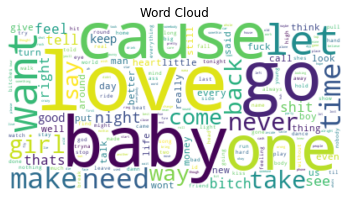

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(collocations = False, 
                      background_color = 'white').generate(' '.join(df_en['LyricsClean']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud")
plt.show()

In [49]:
#Show the sentiment of the songs by years/count

song_sent = pd.DataFrame(df_en.groupby(['Top100Year','sentiment'])['SongTitle'].count())
song_sent.columns = ['SongCount']

song_sent = song_sent.reset_index()
song_sent = song_sent.sort_values(by=['Top100Year','SongCount'], ascending = False)

fig = px.bar(song_sent, x='Top100Year', y='SongCount', color='sentiment',
             labels={'Top100Year': 'Year', 'SongCount': 'Count'},
             title='Top 100 Song Sentiments',
             height=400, width=900)
fig.show()

In [50]:
data = pd.DataFrame(df_en.value_counts(['Top100Year','sentiment']),columns = ['NoOfSongs']).reset_index()
data = data.sort_values(by="Top100Year")
fig = px.line(data, x="Top100Year", y="NoOfSongs", color='sentiment', labels={'Top100Year': 'Year', 'NoOfSongs': 'Count'})
fig.show()

In [51]:
# Filtering songs with postive, negative and neutral sentiments seperately
pos_sent = df_en[df_en['sentiment']=='Positive']
neg_sent = df_en[df_en['sentiment']=='Negative']
neu_sent = df_en[df_en['sentiment']=='Neutral']

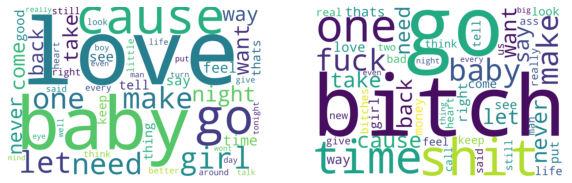

In [52]:
#Analyzing the most common words in positive and negative sentiments
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
wordcloud1 = WordCloud(collocations = False, 
                      background_color = 'white',max_words = 50,
                      width=3000, height=2000).generate(' '.join(pos_sent['LyricsClean']))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")

plt.subplot(1,2,2)
wordcloud2 = WordCloud(collocations = False, 
                      background_color = 'white',max_words = 50,
                      width=3000, height=2000).generate(' '.join(neg_sent['LyricsClean']))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")

plt.show()

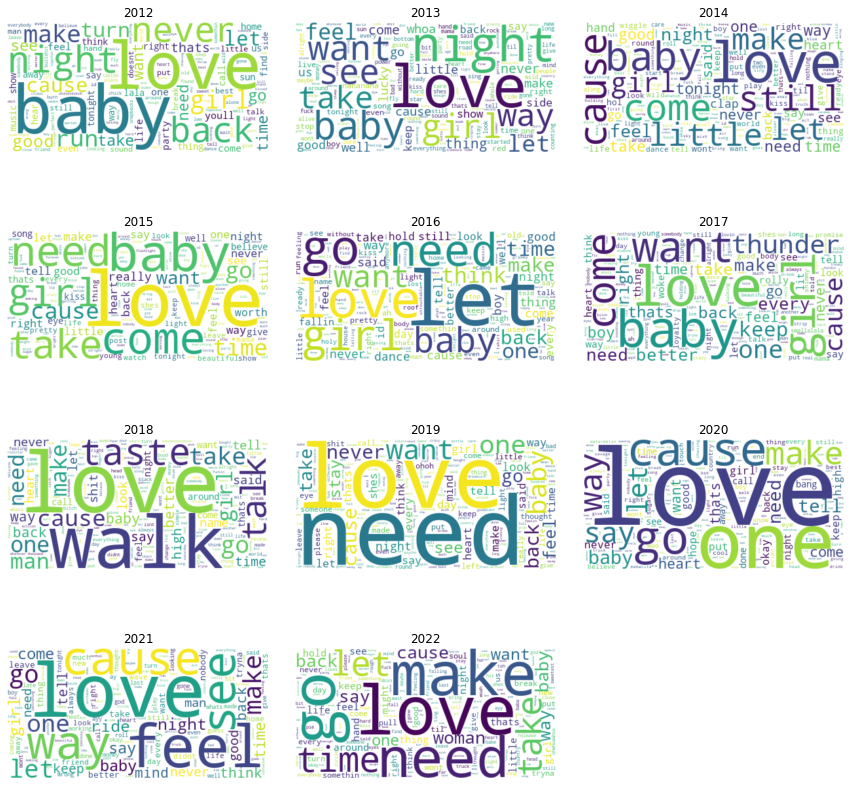

In [53]:
#Analyzing the most common words in positive sentiments by years
from wordcloud import WordCloud
import matplotlib.pyplot as plt
index=1
year = [i for i in range(2012,2023)]
plt.figure(figsize=(15,15))
for y in year:
    d = pos_sent[pos_sent['Top100Year']==y]
    wordcloud = WordCloud(collocations = False, 
                          background_color = 'white').generate(' '.join(d['LyricsClean']))
    plt.subplot(4,3,index)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(y)
    index+=1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

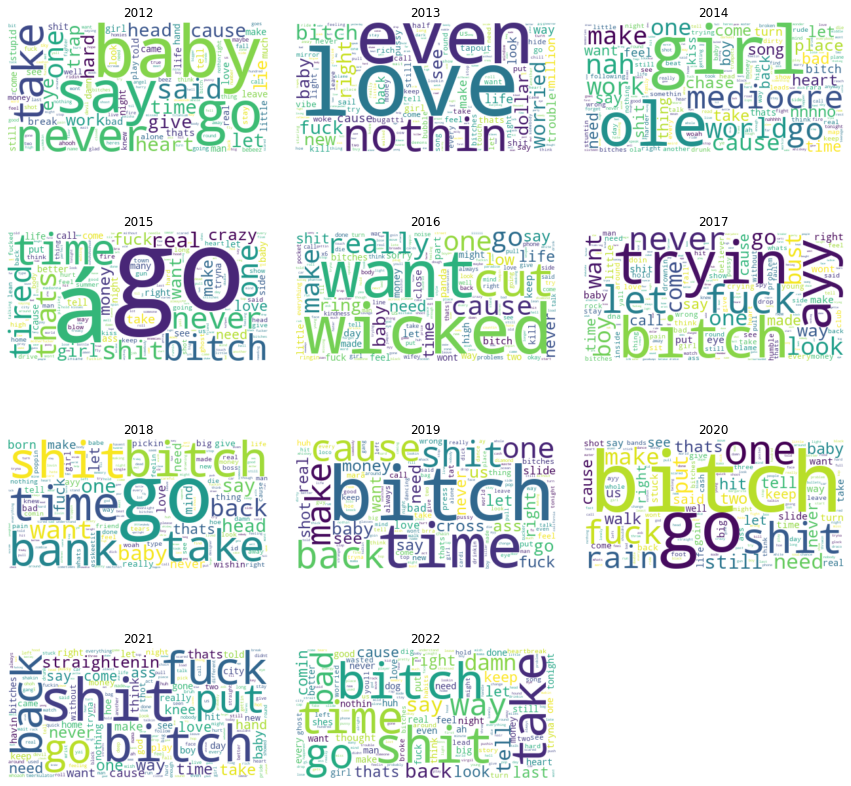

In [54]:
#Analyzing the most common words in negative sentiments by years
from wordcloud import WordCloud
import matplotlib.pyplot as plt
index=1
year = [i for i in range(2012,2023)]
plt.figure(figsize=(15,15))
for y in year:
    d = neg_sent[neg_sent['Top100Year']==y]
    wordcloud = WordCloud(collocations = False, 
                          background_color = 'white').generate(' '.join(d['LyricsClean']))
    plt.subplot(4,3,index)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(y)
    index+=1
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

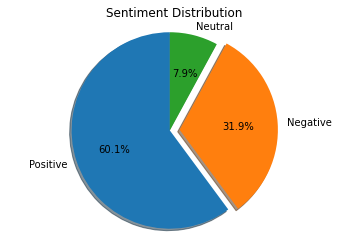

In [55]:
# Calculating the count for each sentiment category
pos_count = len(pos_sent)
neg_count = len(neg_sent)
neu_count = len(neu_sent)

# Creating the pie chart
labels = 'Positive', 'Negative', 'Neutral'
sizes = [pos_count, neg_count, neu_count]
explode = (0, 0.1, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Sentiment Distribution')
plt.show()
